In [1]:
# 1. Import necessary libraries
import pints
import pints.plot
from pints.io import save_samples
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from inv_ccn_utils import * #includes all CCN closure code from Rahul (execute test run, etc. as functions)
from datetime import datetime
import joypy

In [2]:
# Import observations
obs_dir = 'input_data'                    

nsd_abs1 = pd.read_csv(os.path.join(obs_dir, 'NSD_mode1.csv'), parse_dates=['datetime'])  # Load NSD data for mode 1
nsd_abs2 = pd.read_csv(os.path.join(obs_dir, 'NSD_mode2.csv'), parse_dates=['datetime'])  # Load NSD data for mode 2
comp_obs = pd.read_csv(os.path.join(obs_dir, 'comp.csv'), parse_dates=['datetime'])  # Load observed composition data, mass fractions/concentrations
ccn_obs = pd.read_csv(os.path.join(obs_dir, 'CCN.csv'), parse_dates=['datetime'])  # Load observed CCN data
dp_dry = np.loadtxt('Dp.txt')  # Dry particle diameters in nanometers
bimodal_params = pd.read_csv(os.path.join(obs_dir, 'Bimodal_parameters.csv'), parse_dates=['datetime'])  # fitted Bimodal parameters 
bimodal_mad = pd.read_csv(os.path.join(obs_dir, 'MAD.csv'), parse_dates=['datetime'])  # Bimodal median absolute deviation
CCN_all = pd.read_csv(os.path.join(obs_dir, 'CCN_all.csv'), parse_dates=['datetime','start_time','end_time'])  # Load all CCN obs
NSD_params_all = pd.read_csv(os.path.join(obs_dir, 'NSD_PARAMS_SCALED.csv'), parse_dates=['datetime'])  # Load all NSD parameters

if not all(len(df) == len(nsd_abs1) for df in [nsd_abs2, comp_obs, ccn_obs]):
    raise ValueError('Dataframes have different lengths')

Extra = make_EXTRA(dp_dry) # Extra is a dictionary, these initial entries don't change with time.

In [3]:
# look at distributions of M_org1 for idea about how to set up the prior.
# calculate M_org1 depending on fitted NSDs.

M_org1_initial = []
#loop through all timesteps and output the M_org1 values:
for i in range(len(nsd_abs1)):

# Set up ------------------
    # first pre-calculate some parameters:
    NSD1_vec = np.array(nsd_abs1.iloc[i,1:].values) # NSD for mode 1
    NSD2_vec = np.array(nsd_abs2.iloc[i,1:].values) # NSD for mode 2

    response = np.array(ccn_obs.iloc[i,1:].values) # CCN observations at 5 supersaturations

    mass_frac = [
        comp_obs['Org'][i],         # Mass fractions of the components in the particles: [Org, Other, NH4SO4, NH4NO3, BC].
        comp_obs['total_mass'][i],
        comp_obs['NH4SO4'][i],
        comp_obs['NH4NO3'][i],
        comp_obs['eBC880'][i]
        ]

    # mass vectors:
    mass_vec_NH4SO4 = comp_obs['NH4SO4'][i] * comp_obs['total_mass'][i]
    mass_vec_NH4NO3 = comp_obs['NH4NO3'][i] * comp_obs['total_mass'][i]

    # mass fractions
    mass_frac_vec_NH4SO4 = mass_vec_NH4SO4 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)
    mass_frac_vec_NH4NO3 = mass_vec_NH4NO3 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)

    # densities:
    rho_sulp = Extra['densities'][1]   # in kg/m^3
    rho_nitr = Extra['densities'][2]

    # get inorganic density (we include both NH4SO4 and NH4NO3)
    rho_inorg = (mass_frac_vec_NH4SO4 * rho_sulp) + (mass_frac_vec_NH4NO3 * rho_nitr)

    # add to Extra the variables that are calculated each time step:
    Extra['true_inputs'] = mass_frac
    Extra['rho_inorg'] = rho_inorg

    # calculate the mass of the particles in both modes:
    info_mass = cal_mass(dp_dry, Extra['true_inputs'], Extra, NSD1_vec, NSD2_vec)

    M_org1_initial.append(info_mass['M_org1']) # save the M_org1 value for this timestep

(array([4.223e+03, 8.760e+02, 4.710e+02, 3.260e+02, 1.920e+02, 1.330e+02,
        8.600e+01, 6.900e+01, 5.300e+01, 4.100e+01, 2.000e+01, 2.600e+01,
        1.100e+01, 9.000e+00, 6.000e+00, 4.000e+00, 6.000e+00, 7.000e+00,
        2.000e+00, 3.000e+00, 3.000e+00, 4.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.21534253e-06, 1.65817131e-01, 3.31633048e-01, 4.97448964e-01,
        6.63264880e-01, 8.29080796e-01, 9.94896712e-01, 1.16071263e+00,
        1.32652854e+00, 1.49234446e+00, 1.65816038e+00, 1.82397629e+00,
        1.98979221e+00, 2.15560813e+00, 2.32142404e+00, 2.48723996e+00,
        2.65305587e+00, 2.81887179e+00, 2.98468771e+00, 3.15050362e+00,
        3.316319

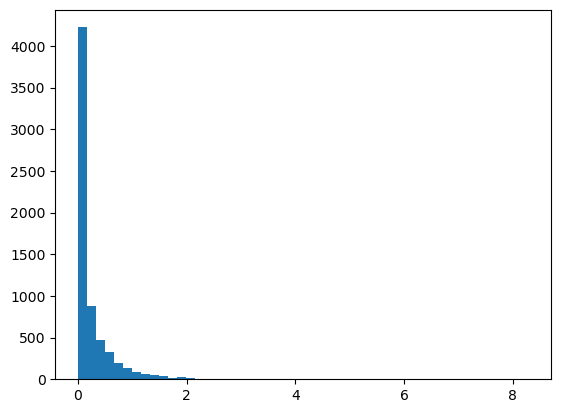

In [137]:
plt.hist(M_org1_initial, bins=50)

In [ ]:
bimodal_mad.loc[bimodal_mad['datetime'] == bimodal_params['datetime'][0]]

,datetime,mode1_d,mode1_sigma,NSD1_sum,mode2_d,mode2_sigma,NSD2_sum
1772,2016-08-16 09:00:00,5.285751,0.0,29.205543,13.313678,0.0,6.156553


In [145]:
bimodal_params.iloc[0]

datetime       2016-08-16 09:00:00
mode1_d                  49.252045
mode1_sigma                   1.75
mode1_n                 130.163625
mode2_d                 170.591083
mode2_sigma                   1.75
mode2_n                 155.644465
Name: 0, dtype: object

In [147]:
NSD_params_all

,datetime,mode1_d,mode1_sigma,mode1_n,mode2_d,mode2_sigma,mode2_n,NSD1_sum,NSD2_sum
0,2016-01-01 00:00:01,24.257639,1.75,598.600795,113.426747,1.75,754.493168,608.788000,777.058013
1,2016-01-01 00:10:00,24.591691,1.75,519.577642,111.437410,1.75,722.740761,518.452691,749.432131
2,2016-01-01 00:20:01,20.970392,1.75,537.384887,105.106872,1.75,742.394200,555.462528,785.728693
3,2016-01-01 00:30:00,24.591691,1.75,593.498833,111.437410,1.75,684.603631,598.729273,711.487335
4,2016-01-01 00:40:01,32.201702,1.75,777.666797,129.955828,1.75,590.103240,832.767204,585.891258
...,...,...,...,...,...,...,...,...,...
168100,2020-12-31 22:50:00,75.330302,1.75,391.141800,223.932377,1.75,50.060356,406.692976,45.771160
168101,2020-12-31 23:00:00,65.381452,1.75,361.936465,170.591083,1.75,102.089841,402.636874,99.342258
168102,2020-12-31 23:10:00,65.381452,1.75,355.440467,170.591083,1.75,110.026332,400.580431,105.183563
168103,2020-12-31 23:20:00,63.955725,1.75,367.152082,167.814816,1.75,103.879694,390.774734,100.053038


(array([1.2502e+04, 7.9000e+01, 1.3100e+02, 5.4000e+01, 2.1400e+02,
        4.5000e+01, 1.2500e+02, 4.5000e+01, 1.5900e+02, 3.9000e+01,
        9.2000e+01, 3.9000e+01, 1.0400e+02, 2.6000e+01, 6.8000e+01,
        2.9000e+01, 7.0000e+01, 2.0000e+01, 5.9000e+01, 1.0400e+02,
        4.0000e+01, 1.3000e+01, 2.5000e+01, 1.3000e+01, 1.9000e+01,
        2.0000e+00, 7.0000e+00, 1.7000e+01, 6.0000e+00, 1.5000e+01,
        5.0000e+00, 1.7000e+01, 2.0000e+00, 1.1000e+01, 4.0000e+00,
        1.3000e+01, 2.0000e+00, 5.0000e+00, 3.0000e+00, 4.3000e+01,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0.   , 0.008, 0.016, 0.024, 0.032, 0.04 , 0.048, 0.056, 0.064,
        0.072, 0.08 , 0.088, 0.096, 0.104, 0.112, 0.12 , 0.128, 0.136,
        0.144, 0.152, 0.16 , 0.168, 0.176, 0.184, 0.192, 0.2  , 0.208,
        0.216, 0.224, 0.232, 0.24 , 0.248, 0.256, 0.264, 0.272, 0.28 ,
        0.288, 0.296, 0.304, 0.312

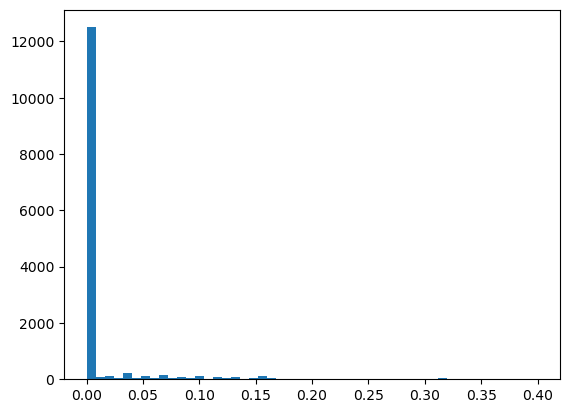

In [140]:
plt.hist(bimodal_mad['mode1_sigma'], bins=50)

In [139]:
bimodal_params

,datetime,mode1_d,mode1_sigma,mode1_n,mode2_d,mode2_sigma,mode2_n
0,2016-08-16 09:00:00,49.252045,1.750000,130.163625,170.591083,1.750000,155.644465
1,2016-08-16 11:00:00,54.537796,1.750000,104.779897,177.922224,1.750000,220.189893
2,2016-08-16 13:00:00,46.506724,1.750000,93.762589,177.922224,1.750000,276.577749
3,2016-08-16 15:00:00,46.506724,1.750000,137.258724,167.814816,1.750000,314.139751
4,2016-08-17 11:00:00,54.537796,1.750000,749.390457,177.922224,1.750000,264.362637
...,...,...,...,...,...,...,...
6575,2020-04-01 11:00:00,14.957140,2.033333,1159.380116,196.369421,1.466667,30.507853
6576,2020-04-01 15:00:00,9.000000,1.666667,2858.552480,129.955828,2.066667,102.449628
6577,2020-04-01 17:00:00,8.740077,1.566667,2774.250567,43.767677,2.066667,551.132402
6578,2020-04-01 19:00:00,13.968558,1.766667,3474.298055,134.925417,1.366667,89.110973


Text(0, 0.5, 'Gaussian PDF')

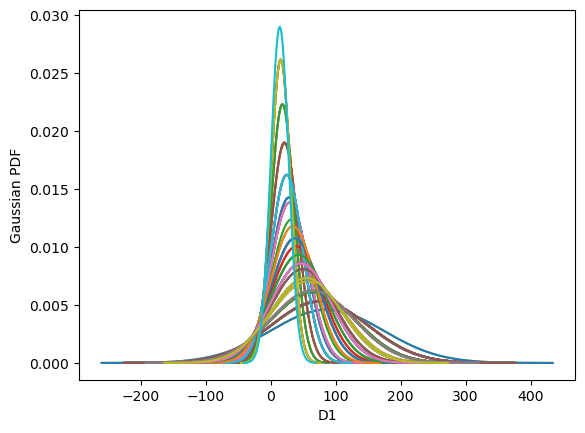

In [4]:
# look at distributions of parameters, assuming gaussian, given mean and MAD:

N1_mean = bimodal_params['mode1_d']
N1_MAD = bimodal_mad['mode1_d']

N1_std = N1_MAD / np.sqrt(2/np.pi) # convert MAD to std

for ii in range(100):
    x = np.linspace(N1_mean[ii] - 4*N1_mean[ii], N1_mean[ii] + 4*N1_mean[ii], 1000)
    pdf = stats.norm.pdf(x, N1_mean[ii], N1_mean[ii])
    plt.plot(x, pdf, label='N1 mean = %s' % N1_mean[ii])
plt.xlabel('D1')
plt.ylabel('Gaussian PDF')

#plt.xlim(100,10000)


Text(0, 0.5, 'Cauchy PDF')

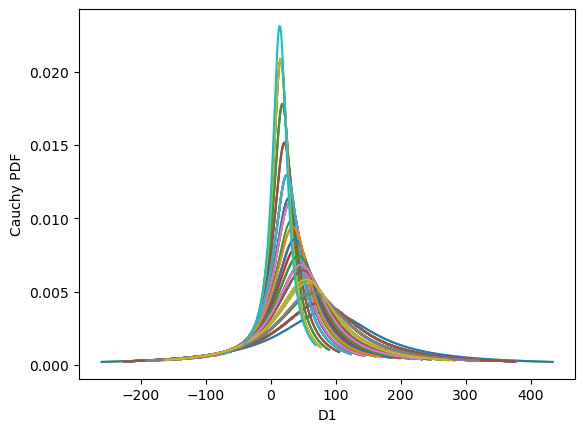

In [5]:
for ii in range(100):
    x = np.linspace(N1_mean[ii] - 4*N1_mean[ii], N1_mean[ii] + 4*N1_mean[ii], 1000)
    pdf = stats.cauchy.pdf(x, N1_mean[ii], N1_mean[ii])
    plt.plot(x, pdf, label='N1 mean = %s' % N1_mean[ii])
plt.xlabel('D1')
plt.ylabel('Cauchy PDF')

In [70]:
# create dataframe for ridgeplot, which is NSD_params_all with extra column for CCN window (and filtered for when there are CCN observations):

filtered_NSD_params = NSD_params_all.copy()

tw_start = CCN_all.loc[CCN_all['datetime']>= '2016-08-16 00:00:00'].reset_index(drop=True)['start_time'] # time window start
tw_end = CCN_all.loc[CCN_all['datetime']>= '2016-08-16 00:00:00'].reset_index(drop=True)['end_time'] # time window end
tw_mid = CCN_all.loc[CCN_all['datetime']>= '2016-08-16 00:00:00'].reset_index(drop=True)['datetime'] # time window mid
window_idx = 0

for i in range(len(tw_start)):
    mask = (
        (filtered_NSD_params['datetime'] >= tw_start[i]) &
        (filtered_NSD_params['datetime'] <= tw_end[i]) &
        (tw_mid[i] in ccn_obs['datetime'].values)
    )
    
    if mask.any():
        filtered_NSD_params.loc[mask, 'CCN_window'] = window_idx
        window_idx += 1

filtered_NSD_params = filtered_NSD_params.dropna(subset=['CCN_window']).reset_index() # drop rows with NaN in CCN_window column



In [ ]:
# add to bimodal params the max and min for d and n in each window:

#NOTE THAT THIS IS SLIGHT OFF BECAUSE OF THE ORDER OF OPERATIONS; BETTER TO USE THE NEW BIMODAL_PARAMS_WINDOWS.CSV DATA

bimodal_params_range = bimodal_params.copy()

for i in range(len(bimodal_params_range)):
    bimodal_params_range.loc[i, 'mode1_d_min'] = filtered_NSD_params.loc[filtered_NSD_params['CCN_window']==i]['mode1_d'].min()
    bimodal_params_range.loc[i, 'mode1_d_max'] = filtered_NSD_params.loc[filtered_NSD_params['CCN_window']==i]['mode1_d'].max()
    bimodal_params_range.loc[i, 'mode2_d_min'] = filtered_NSD_params.loc[filtered_NSD_params['CCN_window']==i]['mode2_d'].min()
    bimodal_params_range.loc[i, 'mode2_d_max'] = filtered_NSD_params.loc[filtered_NSD_params['CCN_window']==i]['mode2_d'].max()
    bimodal_params_range.loc[i, 'mode1_n_min'] = filtered_NSD_params.loc[filtered_NSD_params['CCN_window']==i]['mode1_n'].min()
    bimodal_params_range.loc[i, 'mode1_n_max'] = filtered_NSD_params.loc[filtered_NSD_params['CCN_window']==i]['mode1_n'].max()
    bimodal_params_range.loc[i, 'mode2_n_min'] = filtered_NSD_params.loc[filtered_NSD_params['CCN_window']==i]['mode2_n'].min()
    bimodal_params_range.loc[i, 'mode2_n_max'] = filtered_NSD_params.loc[filtered_NSD_params['CCN_window']==i]['mode2_n'].max()

In [112]:
pd.DataFrame.to_csv(bimodal_params_range, 'bimodal_params_range.csv', index=False)

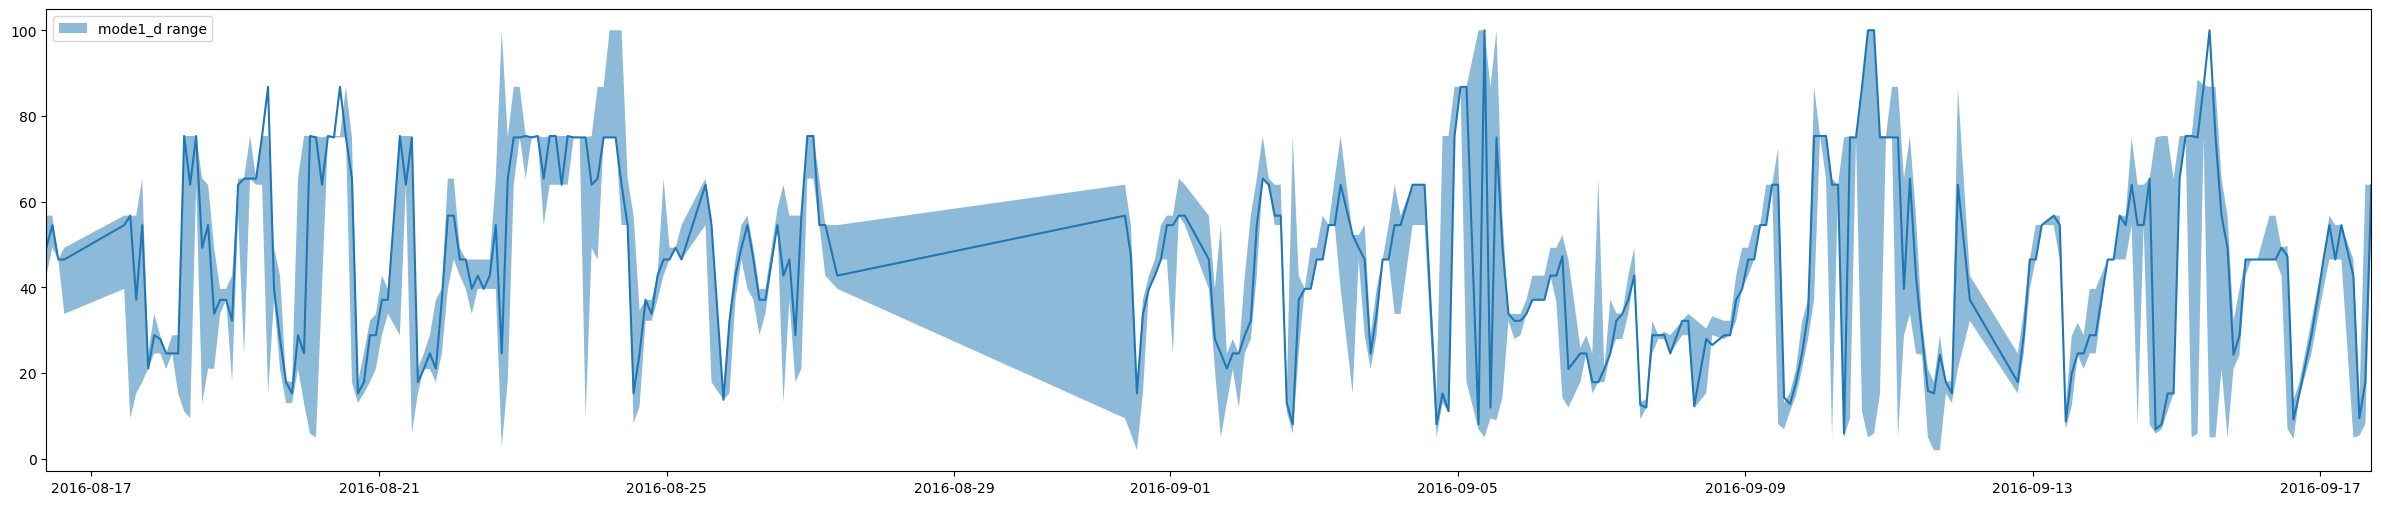

In [134]:
fig = plt.figure(figsize=(30, 6))
data_range = 300
plt.plot(bimodal_params_range[0:data_range]['datetime'],bimodal_params_range[0:data_range]['mode1_d'])
plt.fill_between(bimodal_params_range[0:data_range]['datetime'], bimodal_params_range[0:data_range]['mode1_d_min'], bimodal_params_range[0:data_range]['mode1_d_max'], alpha=0.5, label='mode1_d range')
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()

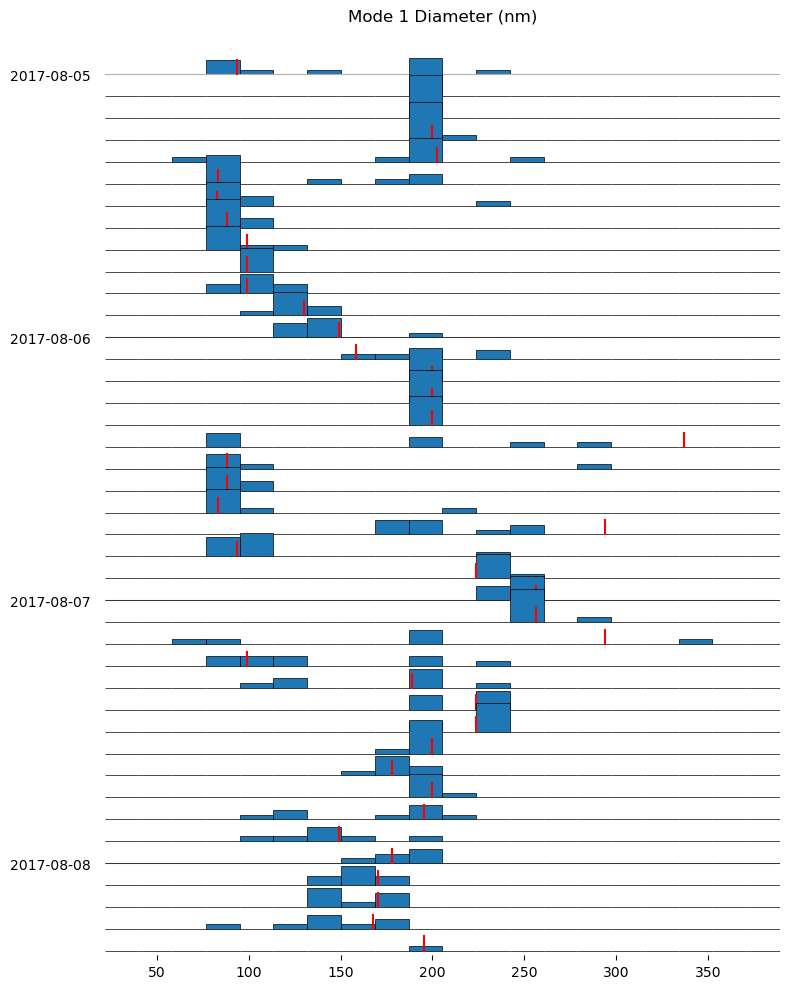

In [93]:
plt_idx1 = 10000
plt_idx2 = 10300

days_list = filtered_NSD_params[plt_idx1:plt_idx2].drop_duplicates('CCN_window')['datetime'].dt.to_period('D').astype(str).tolist()
seen = set()
labels = []

param_idx = filtered_NSD_params[plt_idx1:plt_idx2].drop_duplicates('CCN_window')['CCN_window'].values

for val in days_list:
    if val not in seen:
        labels.append(val)
        seen.add(val)
    else:
        labels.append(None)

f, axs = joypy.joyplot(
    data=filtered_NSD_params[plt_idx1:plt_idx2],
    by='CCN_window',
    column='mode2_d',
    labels=labels,
    range_style='own',
    #x_range = (-10,1500),
    grid='y',
    linewidth=0.5,
    legend=False,
    hist=True,
    #kind='counts',
    bins=20,
    overlap=0.5,
    figsize=(8,10),
    title='Mode 1 Diameter (nm)',
)

for i in range(len(axs)-1):
    d = bimodal_params.loc[param_idx[i]]['mode2_d']
    #yval = axs[i].get_ydata().max()
    axs[i].plot([d,d],[0,3], color='red', zorder=200)

In [75]:
param_idx[17]

1156.0

In [85]:
filtered_NSD_params.where(filtered_NSD_params['CCN_window'] == 1156.0).dropna(subset=['CCN_window'])

,index,datetime,mode1_d,mode1_sigma,mode1_n,mode2_d,mode2_sigma,mode2_n,NSD1_sum,NSD2_sum,CCN_window
10128,53039.0,2017-08-06 10:10:01,75.000000,1.75,620.395500,200.000000,1.75,99.504553,592.541541,96.869455,1156.0
10129,53040.0,2017-08-06 10:20:01,75.330302,1.75,659.841626,256.564860,1.75,88.223259,673.145299,77.531120,1156.0
10130,53041.0,2017-08-06 10:30:00,75.000000,1.75,632.121184,200.000000,1.75,118.927736,607.164298,112.785988,1156.0
10131,53042.0,2017-08-06 10:40:01,86.793031,1.75,672.424570,293.952702,1.75,37.941039,702.313984,31.556598,1156.0
10132,53043.0,2017-08-06 10:50:00,8.063350,1.75,38.429673,83.182413,1.75,667.544241,35.948668,666.293463,1156.0
10133,53044.0,2017-08-06 11:40:00,11.088663,1.75,366.569390,83.182413,1.75,624.312335,372.508516,610.854214,1156.0
10134,53045.0,2017-08-06 11:50:01,11.088663,1.75,363.248490,88.192452,1.75,692.790372,355.721603,676.558113,1156.0


In [90]:
filtered_NSD_params.where(filtered_NSD_params['CCN_window'] == 1156.0).dropna(subset=['CCN_window'])['mode2_n'].median() # median of mode 2 diameter for CCN window 1156.0

118.92773553201056

In [80]:
bimodal_params.loc[1156]

datetime       2017-08-06 11:00:00
mode1_d                  86.793031
mode1_sigma                   1.75
mode1_n                 664.685935
mode2_d                 336.788876
mode2_sigma                   1.75
mode2_n                  30.752517
Name: 1156, dtype: object

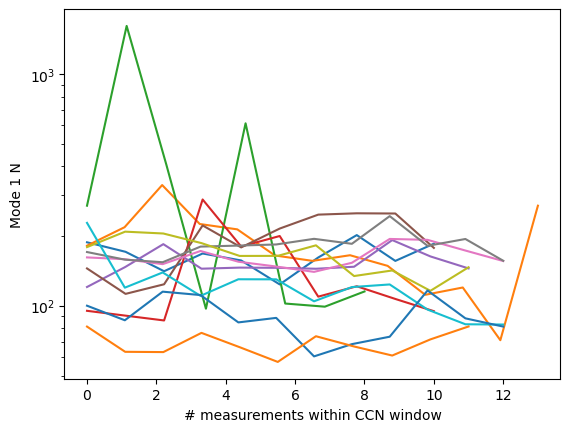

In [23]:
#look at variability of mode 1 D:
mode1_d = []

tw_start = CCN_all.loc[CCN_all['datetime']>= '2016-01-01 00:00:00'].reset_index(drop=True)['start_time'] # time window start
tw_end = CCN_all.loc[CCN_all['datetime']>= '2016-01-01 00:00:00'].reset_index(drop=True)['end_time'] # time window end

for ii in range(100):
    data = NSD_params_all.loc[(NSD_params_all['datetime'] >= tw_start[ii]) & (NSD_params_all['datetime'] <= tw_end[ii])]
    if len(data)==0:
        mode1_d.append(np.nan)
    else:
        mode1_d.append(data['mode1_n'])
        plt.semilogy(np.linspace(0,len(data),len(data)),data['mode1_n'])
        #plt.plot(13, np.mean(data['mode1_d']), 'o')
        plt.ylabel('Mode 1 N')
        plt.xlabel('# measurements within CCN window')
       


In [83]:
filtered_NSD_params.loc[filtered_NSD_params['CCN_window'] == 40]

,datetime,mode1_d,mode1_sigma,mode1_n,mode2_d,mode2_sigma,mode2_n,NSD1_sum,NSD2_sum,CCN_window
20101,2016-08-20 10:00:01,75.330302,1.75,1536.335141,170.591083,1.75,845.708361,1489.554805,806.127905,40.0
20102,2016-08-20 10:10:00,75.330302,1.75,1482.314695,170.591083,1.75,862.640314,1427.876154,824.321475,40.0
20103,2016-08-20 10:30:00,75.330302,1.75,1398.284507,170.591083,1.75,936.931543,1338.588417,890.919006,40.0
20104,2016-08-20 10:40:01,75.330302,1.75,1369.122737,170.591083,1.75,962.566060,1352.880445,914.447157,40.0
20105,2016-08-20 10:50:00,75.330302,1.75,1369.335267,170.591083,1.75,954.510151,1310.869315,899.310113,40.0
20106,2016-08-20 11:00:00,75.330302,1.75,1323.349023,170.591083,1.75,988.349823,1319.369814,934.400598,40.0
20107,2016-08-20 11:10:01,75.330302,1.75,1276.972913,170.591083,1.75,1036.691865,1234.772557,975.924770,40.0
20108,2016-08-20 11:20:00,75.000000,1.75,1080.476750,149.289926,1.75,1194.648976,1039.067938,1169.275971,40.0
20109,2016-08-20 11:30:01,75.000000,1.75,1081.989821,149.289926,1.75,1229.757108,1064.485168,1197.388985,40.0
20110,2016-08-20 11:40:00,75.000000,1.75,1044.475287,149.289926,1.75,1234.723536,998.685876,1207.674422,40.0


In [96]:
bimodal_params.loc[40]

datetime       2016-08-20 11:00:00
mode1_d                  86.793031
mode1_sigma                   1.75
mode1_n                1630.759354
mode2_d                  195.45042
mode2_sigma                   1.75
mode2_n                 662.891885
Name: 40, dtype: object

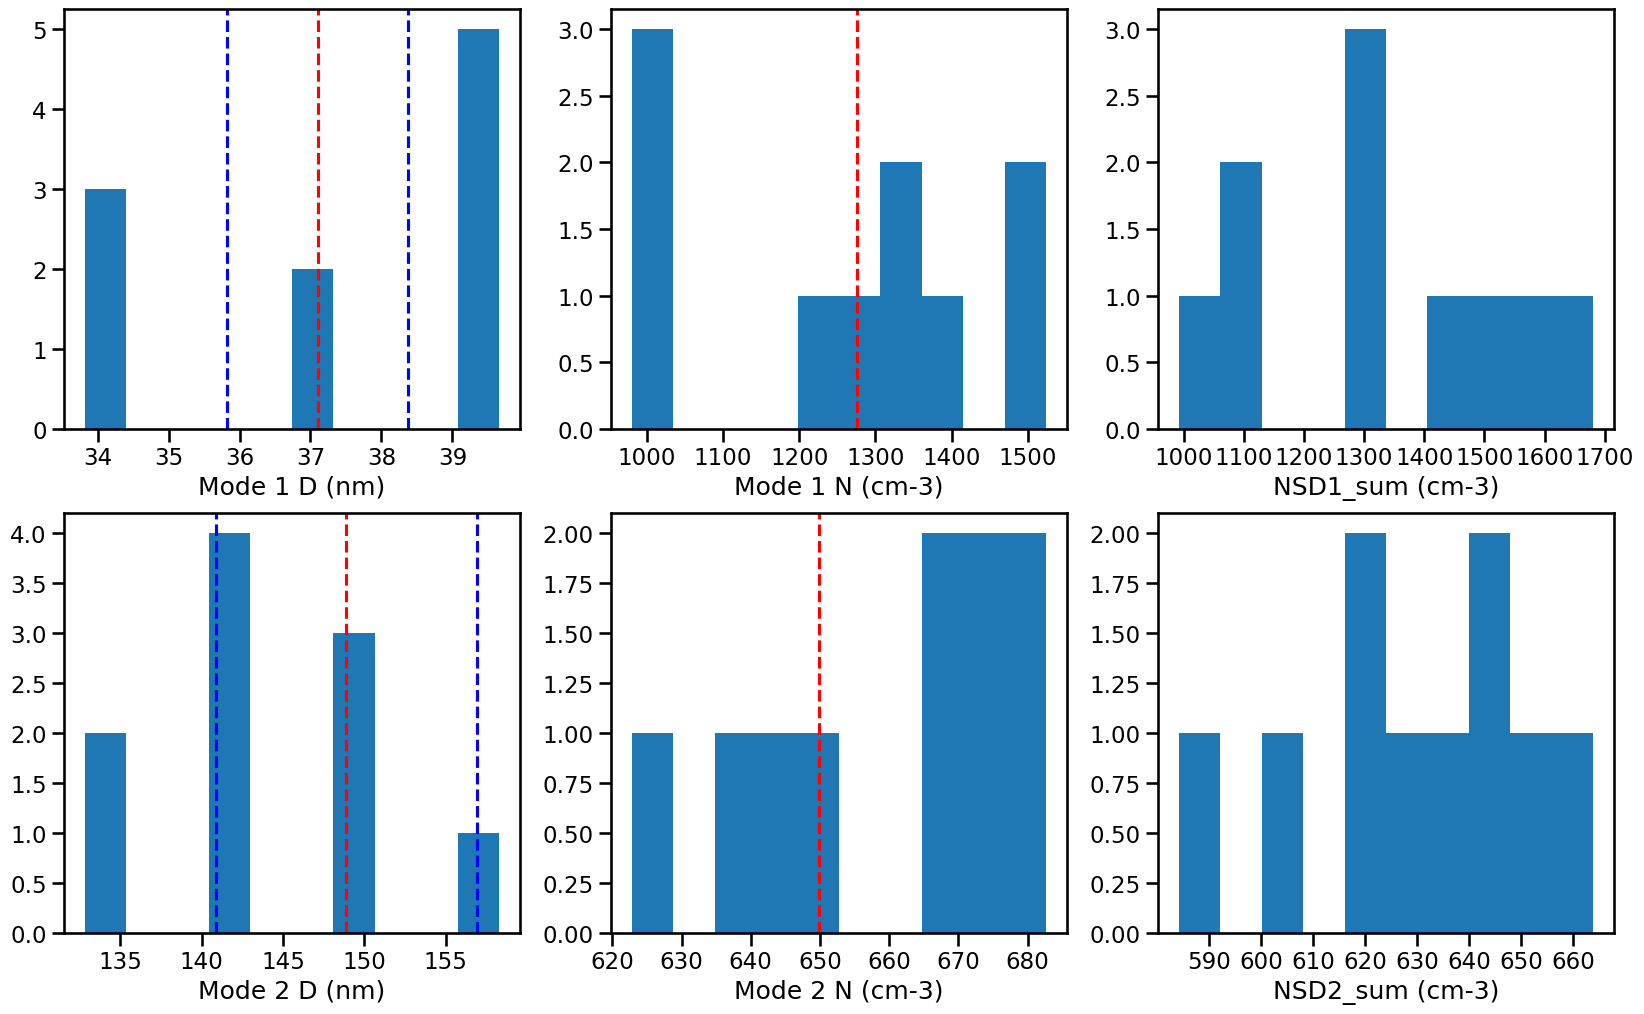

In [95]:
# histograms for one particular window (20th CCN obs, which we have been using for testing MCMC method):

idx = 20
plt_date = bimodal_params.loc[idx].datetime
MAD_params = bimodal_mad.loc[bimodal_mad['datetime'] == plt_date]


with sns.plotting_context('talk'):
    fig, axs = plt.subplots(2, 3, figsize=(20,12))
    axs = axs.flatten()

    axs[0].hist(filtered_NSD_params.loc[filtered_NSD_params['CCN_window'] == idx]['mode1_d'], bins=10)
    axs[0].set_xlabel('Mode 1 D (nm)')
    axs[0].axvline(bimodal_params.loc[idx]['mode1_d'], color='red', linestyle='--', label='median')
    axs[0].axvline(bimodal_params.loc[idx]['mode1_d']+MAD_params['mode1_d'].values, color='blue', linestyle='--')
    axs[0].axvline(bimodal_params.loc[idx]['mode1_d']-MAD_params['mode1_d'].values, color='blue', linestyle='--')

    axs[1].hist(filtered_NSD_params.loc[filtered_NSD_params['CCN_window'] == idx]['mode1_n'], bins=10)
    axs[1].set_xlabel('Mode 1 N (cm-3)')
    axs[1].axvline(bimodal_params.loc[idx]['mode1_n'], color='red', linestyle='--', label='median')

    axs[2].hist(filtered_NSD_params.loc[filtered_NSD_params['CCN_window'] == idx]['NSD1_sum'], bins=10)
    axs[2].set_xlabel('NSD1_sum (cm-3)')
    #axs[2].axvline(bimodal_params.loc[idx]['NSD1_sum'], color='red', linestyle='--', label='median')

    axs[3].hist(filtered_NSD_params.loc[filtered_NSD_params['CCN_window'] == idx]['mode2_d'], bins=10)
    axs[3].set_xlabel('Mode 2 D (nm)')
    axs[3].axvline(bimodal_params.loc[idx]['mode2_d'], color='red', linestyle='--', label='median')
    axs[3].axvline(bimodal_params.loc[idx]['mode2_d']+MAD_params['mode2_d'].values, color='blue', linestyle='--')
    axs[3].axvline(bimodal_params.loc[idx]['mode2_d']-MAD_params['mode2_d'].values, color='blue', linestyle='--')

    axs[4].hist(filtered_NSD_params.loc[filtered_NSD_params['CCN_window'] == idx]['mode2_n'], bins=10)
    axs[4].set_xlabel('Mode 2 N (cm-3)')
    axs[4].axvline(bimodal_params.loc[idx]['mode2_n'], color='red', linestyle='--', label='median')

    axs[5].hist(filtered_NSD_params.loc[filtered_NSD_params['CCN_window'] == idx]['NSD2_sum'], bins=10)
    axs[5].set_xlabel('NSD2_sum (cm-3)')
    #axs[5].axvline(bimodal_params.loc[idx]['NSD2_sum'], color='red', linestyle='--', label='median')


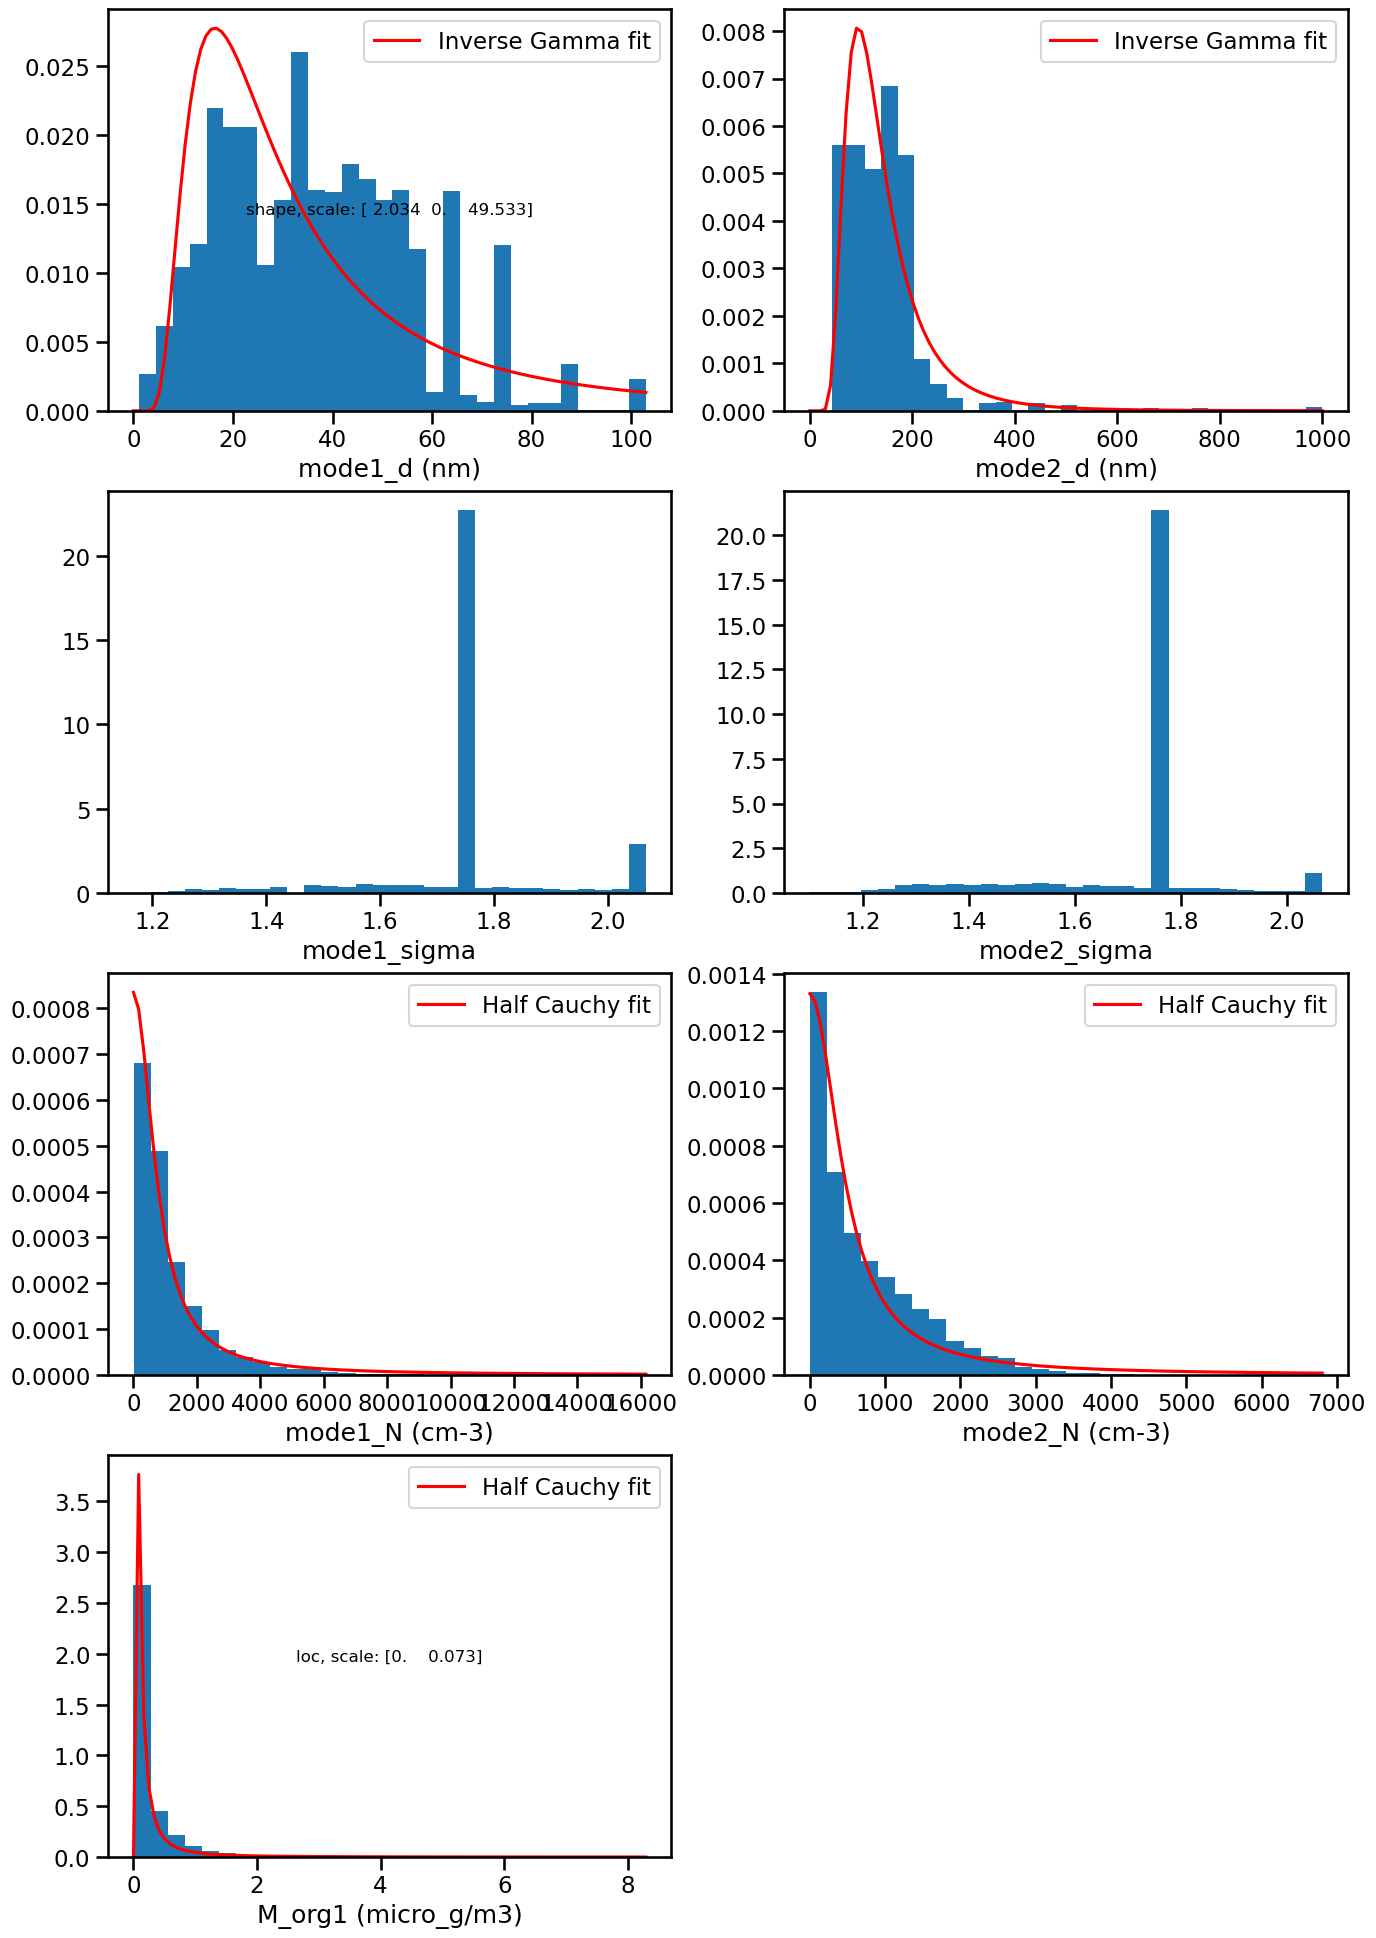

In [7]:
#plot initial values and priors for 6 modal parameters and M_org1:

with sns.plotting_context('talk'):
    fig, axs = plt.subplots(4,2,figsize=(16, 24))
    axs = axs.flatten()

    axs[0].hist(bimodal_params['mode1_d'], bins=30, density=True)
    axs[0].set_xlabel('mode1_d (nm)')
    mode1d_fit = stats.invgamma.fit(bimodal_params['mode1_d'],floc=0)
    axs[0].plot(np.linspace(0, np.array(bimodal_params['mode1_d']).max(), 100), stats.invgamma.pdf(np.linspace(0, np.array(bimodal_params['mode1_d']).max(), 100), *mode1d_fit), color='red', label='Inverse Gamma fit')
    axs[0].annotate('shape, scale: ' + str(np.round(mode1d_fit,3)), xy=(0.5, 0.5), xycoords='axes fraction', fontsize=12, ha='center', va='center')
    axs[0].legend()

    axs[1].hist(bimodal_params['mode2_d'], bins=30, density=True)
    axs[1].set_xlabel('mode2_d (nm)')
    mode2d_fit = stats.invgamma.fit(bimodal_params['mode2_d'],floc=0)
    axs[1].plot(np.linspace(0, np.array(bimodal_params['mode2_d']).max(), 100), stats.invgamma.pdf(np.linspace(0, np.array(bimodal_params['mode2_d']).max(), 100), *mode2d_fit), color='red', label='Inverse Gamma fit')
    axs[1].legend()

    axs[2].hist(bimodal_params['mode1_sigma'], bins=30, density=True)
    axs[2].set_xlabel('mode1_sigma')

    axs[3].hist(bimodal_params['mode2_sigma'], bins=30, density=True)
    axs[3].set_xlabel('mode2_sigma')

    axs[4].hist(bimodal_params['mode1_n'], bins=30, density=True)
    axs[4].set_xlabel('mode1_N (cm-3)')
    mode1_fit = stats.halfcauchy.fit(bimodal_params['mode1_n'],floc=0)
    axs[4].plot(np.linspace(0, np.array(bimodal_params['mode1_n']).max(), 100), stats.halfcauchy.pdf(np.linspace(0, np.array(bimodal_params['mode1_n']).max(), 100), *mode1_fit), color='red', label='Half Cauchy fit')
    #axs[4].annotate('shape, scale: ' + str(np.round(mode1_fit,3)), xy=(0.5, 0.5), xycoords='axes fraction', fontsize=12, ha='center', va='center')
    axs[4].legend()

    axs[5].hist(bimodal_params['mode2_n'], bins=30, density=True)
    axs[5].set_xlabel('mode2_N (cm-3)')
    mode2_fit = stats.halfcauchy.fit(bimodal_params['mode2_n'],floc=0)
    axs[5].plot(np.linspace(0, np.array(bimodal_params['mode2_n']).max(), 100), stats.halfcauchy.pdf(np.linspace(0, np.array(bimodal_params['mode2_n']).max(), 100), *mode2_fit), color='red', label='Half Cauchy fit')
    axs[5].legend()

    axs[6].hist(M_org1_initial, bins=30, density=True)
    axs[6].set_xlabel('M_org1 (micro_g/m3)')
    # Prior fit:
    morg_fit = stats.halfcauchy.fit(M_org1_initial) 
    axs[6].plot(np.linspace(0, np.array(M_org1_initial).max(), 100), stats.halfcauchy.pdf(np.linspace(0, np.array(M_org1_initial).max(), 100), *morg_fit), color='red', label='Half Cauchy fit')
    axs[6].legend()
    axs[6].annotate('loc, scale: ' + str(np.round(morg_fit,3)), xy=(0.5, 0.5), xycoords='axes fraction', fontsize=12, ha='center', va='center')

    axs[7].set_axis_off()

In [22]:
bimodal_params

,datetime,mode1_d,mode1_sigma,mode1_n,mode2_d,mode2_sigma,mode2_n
0,2016-08-16 09:00:00,49.252045,1.750000,130.163625,170.591083,1.750000,155.644465
1,2016-08-16 11:00:00,54.537796,1.750000,104.779897,177.922224,1.750000,220.189893
2,2016-08-16 13:00:00,46.506724,1.750000,93.762589,177.922224,1.750000,276.577749
3,2016-08-16 15:00:00,46.506724,1.750000,137.258724,167.814816,1.750000,314.139751
4,2016-08-17 11:00:00,54.537796,1.750000,749.390457,177.922224,1.750000,264.362637
...,...,...,...,...,...,...,...
6575,2020-04-01 11:00:00,14.957140,2.033333,1159.380116,196.369421,1.466667,30.507853
6576,2020-04-01 15:00:00,9.000000,1.666667,2858.552480,129.955828,2.066667,102.449628
6577,2020-04-01 17:00:00,8.740077,1.566667,2774.250567,43.767677,2.066667,551.132402
6578,2020-04-01 19:00:00,13.968558,1.766667,3474.298055,134.925417,1.366667,89.110973


(24.833171369202944, -57.115242720688535, 2255.1452752247505)